<a href="https://colab.research.google.com/github/SSAC-AI/AI/blob/main/SSAC_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


[Step 0] Train Loss: 2.3568, Test Loss: 2.4428
[Step 5000] Train Loss: 0.1935, Test Loss: 0.2791
[Step 10000] Train Loss: 0.3583, Test Loss: 0.1805

⏱ Training Time: 85.86 seconds


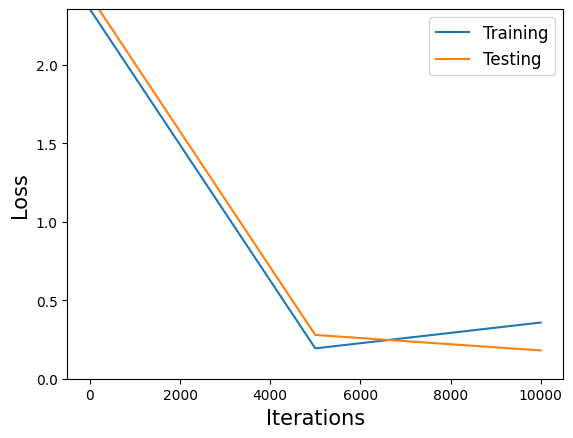


✅ Final Test Accuracy: 93.10%


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

# 1. 데이터 로딩 및 전처리
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=50, shuffle=False)

# 2. 모델 정의 (1 hidden layer, sigmoid)
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(28*28, 100)  # 입력 784 → 은닉층 100
        self.output = nn.Linear(100, 10)     # 은닉층 100 → 출력층 10

    def forward(self, x):
        x = x.view(-1, 28*28)               # [batch, 1, 28, 28] → [batch, 784]
        x = torch.sigmoid(self.hidden(x))  # 은닉층 + sigmoid 활성화
        x = self.output(x)                 # 출력층 (softmax는 loss에서 처리)
        return x

# 3. 모델, 손실함수, 옵티마이저 설정
model = MLP()
criterion = nn.CrossEntropyLoss()                  # 내부적으로 softmax 포함
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 4. 학습 설정
n_iter = 50001
print_interval = 5000

# 5. 학습 루프
loss_record_train = []
loss_record_test = []
start_time = time.time()

step = 0
model.train()
for epoch in range(10):  # epoch 수는 충분히 크게 설정 (step 제한 있음)
    for images, labels in train_loader:
        outputs = model(images)                      # forward
        loss = criterion(outputs, labels)            # 손실 계산
        optimizer.zero_grad()                        # 기울기 초기화
        loss.backward()                              # 역전파
        optimizer.step()                             # 가중치 업데이트

        # 일정 간격마다 학습 & 테스트 손실 기록
        if step % print_interval == 0:
            # 학습 손실
            loss_train = loss.item()
            loss_record_train.append(loss_train)

            # 테스트 손실 측정
            model.eval()
            test_images, test_labels = next(iter(test_loader))
            with torch.no_grad():
                test_outputs = model(test_images)
                loss_test = criterion(test_outputs, test_labels).item()
                loss_record_test.append(loss_test)
            model.train()

            # 출력
            print(f"[Step {step}] Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}")

        step += 1
        if step > n_iter:
            break
    if step > n_iter:
        break

training_time = time.time() - start_time
print(f"\n⏱ Training Time: {training_time:.2f} seconds")

# 6. 손실 그래프 출력
plt.plot([i * print_interval for i in range(len(loss_record_train))], loss_record_train, label='Training')
plt.plot([i * print_interval for i in range(len(loss_record_test))], loss_record_test, label='Testing')
plt.xlabel('Iterations', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=12)
plt.ylim([0, max(loss_record_train)])
plt.savefig('Example5_MLP_training.jpeg', dpi=300)
plt.show()

# 7. 정확도 측정 (선택)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = 100 * correct / total
print(f"\n✅ Final Test Accuracy: {accuracy:.2f}%")

Accuracy : 92.97%


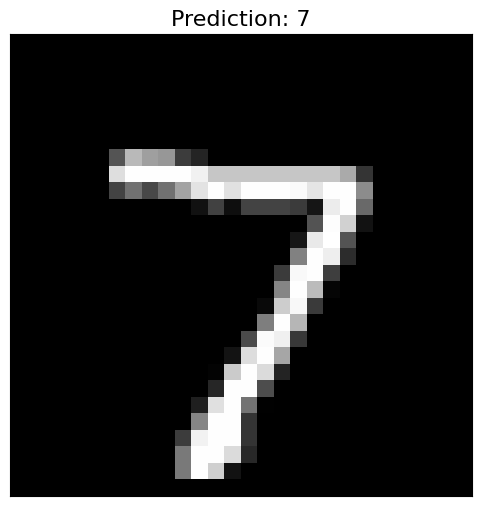

Probability: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. 전체 테스트 세트 정확도 측정
model.eval()  # 평가 모드로 전환 (Dropout/BN 비활성화 등)
correct = 0
total = 0

with torch.no_grad():  # 기울기 계산 비활성화 (메모리 절약)
    for images, labels in test_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print("Accuracy : {:.2f}%".format(accuracy))

# 2. 이미지 1개 예측 및 시각화
model.eval()
with torch.no_grad():
    image, label = next(iter(test_loader))  # 배치 중 1개 가져오기
    image = image[0].unsqueeze(0)  # [1, 1, 28, 28]
    label = label[0].item()

    output = model(image)
    probs = torch.softmax(output, dim=1).squeeze().numpy()
    prediction = np.argmax(probs)

    # 이미지 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"Prediction: {prediction}", fontsize=16)
    plt.show()

    # 확률 출력
    np.set_printoptions(precision=2, suppress=True)
    print(f'Probability: {probs}')

CNN Structure

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # 1st Convolution Layer: input (1, 28, 28) → output (32, 28, 28)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # (32, 14, 14)

        # 2nd Convolution Layer: input (32, 14, 14) → output (64, 14, 14)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # (64, 7, 7)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))  # (32, 28, 28)
        x = self.pool1(x)          # (32, 14, 14)

        x = F.relu(self.conv2(x))  # (64, 14, 14)
        x = self.pool2(x)          # (64, 7, 7)

        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 64*7*7)
        x = F.relu(self.fc1(x))    # (batch_size, 100)
        x = self.fc2(x)            # (batch_size, 10)

        return x

model = CNN()
print(model)

sample_input = torch.randn(16, 1, 28, 28)
output = model(sample_input)

print(output.shape)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)
torch.Size([16, 10])


In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution Layer 1: (1 input channel → 32 output channels, 3x3 kernel, padding=1)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)

        # Convolution Layer 2: (32 → 64)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        # 이미지 크기 28x28 → 풀링 2번 후 7x7 → 7x7x64 = 3136
        self.fc1 = nn.Linear(in_features=7*7*64, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        # Conv1 + ReLU + Pool
        x = self.pool(F.relu(self.conv1(x)))

        # Conv2 + ReLU + Pool
        x = self.pool(F.relu(self.conv2(x)))

        # Flatten
        x = x.view(x.size(0), -1)  # [batch_size, 3136]

        # FC1 + ReLU
        x = F.relu(self.fc1(x))

        # FC2 (Output)
        x = self.fc2(x)
        return x

model = CNNModel()

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류용
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# 데이터 예시 (MNIST처럼 1채널 28x28 입력)
x = torch.randn(16, 1, 28, 28)  # [batch_size, channels, height, width]
output = model(x)
print("Output shape:", output.shape)  # torch.Size([16, 10])

Output shape: torch.Size([16, 10])


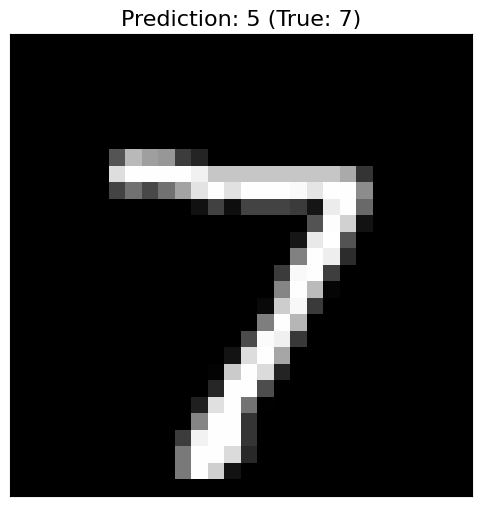

Class Probabilities: [0.11 0.1  0.09 0.1  0.11 0.12 0.09 0.1  0.1  0.09]


In [9]:
import numpy as np

model.eval()

# MNIST test_loader에서 한 배치 가져오기
with torch.no_grad():
    image_batch, label_batch = next(iter(test_loader))  # [batch, 1, 28, 28]
    image = image_batch[0].unsqueeze(0)  # [1, 1, 28, 28]
    true_label = label_batch[0].item()

    # 예측
    output = model(image)
    probs = torch.softmax(output, dim=1).squeeze().numpy()
    prediction = np.argmax(probs)

# 🔍 이미지 시각화
plt.figure(figsize=(6, 6))
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Prediction: {prediction} (True: {true_label})", fontsize=16)
plt.xticks([])
plt.yticks([])
plt.show()

# 🔢 확률 출력
np.set_printoptions(precision=2, suppress=True)
print("Class Probabilities:", probs)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()

        # 1st Convolution Layer: input channels=1, output channels=32, kernel size=3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # SAME padding

        # 2nd Convolution Layer: input channels=32, output channels=64, kernel size=3x3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # SAME padding

        # MaxPool layers (kernel size=2x2, stride=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # VALID padding by default

        # After 2 maxpools (each halves the size): 28x28 → 14x14 → 7x7
        # Flattened size = 7*7*64 = 3136
        self.fc1 = nn.Linear(in_features=7*7*64, out_features=100)  # Hidden layer
        self.fc2 = nn.Linear(in_features=100, out_features=10)      # Output layer (10 classes)

    def forward(self, x):
        # Input shape: [batch_size, 1, 28, 28]

        x = self.conv1(x)             # Conv1
        x = F.relu(x)
        x = self.pool(x)              # MaxPool1

        x = self.conv2(x)             # Conv2
        x = F.relu(x)
        x = self.pool(x)              # MaxPool2

        x = x.view(x.size(0), -1)     # Flatten
        x = self.fc1(x)               # Fully Connected Hidden
        x = F.relu(x)
        x = self.fc2(x)               # Output (logits)

        return x

if __name__ == "__main__":
    model = MyCNN()
    sample_input = torch.randn(1, 1, 28, 28)  # [batch_size, channels, height, width]
    output = model(sample_input)
    print(output.shape)  # torch.Size([1, 10])

torch.Size([1, 10])
